In [1]:
import jupyterthemes as jt
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
!jt -t onedork -ofs 12 -dfs 12 -fs 12 -cellw 100% -T # onedork, grade3
#!jt -r
# source activate rdkit && 

In [2]:
import re, os, glob
import image_slicer
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="5,6,7,8"
os.environ["CUDA_VISIBLE_DEVICES"]="8"

In [3]:
from fastai import *
from fastai.vision import *
from fastai.core import *
from fastai.callbacks.hooks import *
from fastai.metrics import error_rate
import matplotlib.pyplot as plt
import re, os, glob
import torch
from PIL import Image

In [4]:
from patches import extract_patches_2d
from patches import reconstruct_from_patches_2d

In [5]:
BS=8
VALID_PCT=0.2

In [6]:
def symmetrise_data(df_i, col_name_output='treatment', n_samples=None, remove_one=False):
    
    if n_samples is None:
        n_samples = min(df_i[df_i[col_name_output] == 'ab'].shape[0], 
                       df_i[df_i[col_name_output] == 'veh'].shape[0])
        
    if remove_one:
        n_samples -= 1
    
    
    tmp = pd.concat([df_i[df_i[col_name_output] == 'ab'].sample(n_samples), 
                     df_i[df_i[col_name_output] == 'veh'].sample(n_samples)], axis=0)
    
    return tmp

In [7]:
torch.cuda.device_count()

1

In [8]:
torch.cuda.current_device()

0

In [9]:
os.getcwd()

'/mnt/sdf/adam'

In [10]:

base_path = os.path.join('/mnt', 'sdf')
base_path

'/mnt/sdf'

In [11]:
path_to_images = os.path.join(base_path, 'training_data')
path_to_images

'/mnt/sdf/training_data'

In [12]:
path_to_dfs = os.path.join(base_path, 'training_data', 'dfs')
path_to_dfs

'/mnt/sdf/training_data/dfs'

In [13]:
# create a single dataframe with all file names and labels
dfs_filenames = glob.glob(os.path.join(path_to_dfs, '*.csv'))  
# return a list of csv in the path
# each csv name represents a candidate drug name?

dfs = []
for filename_i in dfs_filenames:
    dfs.append(pd.read_csv(filename_i))
    
dfs = pd.concat(dfs, axis=0)

In [14]:
dfs[['filename_new', 'treatment']].shape

(16548, 2)

In [15]:
# validation of the data set

a_0 = dfs.filename_new.tolist()
a_0_new = ['/mnt/sdf/training_data/' + i for i in a_0]
b_0 = glob.glob(os.path.join(path_to_images, '*.tif'))

print(len(a_0_new))
print(len(b_0))
# more file names than actual image files

missing_files = list(set(a_0_new) - set(b_0))
print(len(missing_files))

16548
16524
24


In [16]:
missing_files = [re.sub('/mnt/sdf/training_data/', '',i) for i in missing_files]
missing_files[:5]

['caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_e - 9(fld 8 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_f - 9(fld 21 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_f - 9(fld 22 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_d - 6(fld 19 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_3 - doxylamine_40x_6-4-18_40x_assay plate 0_3_2018.04.06.20.10.49_d - 4(fld 1 wv red - cy5).tif']

In [17]:
missing_files += ['caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_3 - doxylamine_40x_6-4-18_40x_assay plate 0_3_2018.04.06.20.10.49_d - 4(fld 28 wv red - cy5).tif']
print(len(missing_files))
missing_files[:5]

25


['caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_e - 9(fld 8 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_f - 9(fld 21 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_f - 9(fld 22 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_d - 6(fld 19 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_3 - doxylamine_40x_6-4-18_40x_assay plate 0_3_2018.04.06.20.10.49_d - 4(fld 1 wv red - cy5).tif']

In [18]:
dfs.treatment.value_counts()

veh    8276
ab     8272
Name: treatment, dtype: int64

In [19]:
dfs = dfs[~(dfs.filename_new.isin(missing_files))].copy()

In [20]:
dfs.treatment.value_counts()

ab     8264
veh    8260
Name: treatment, dtype: int64

# Preparing databunch

In [25]:
# datasets.ImageFolder(
#         root=data_path,
#         transform=torchvision.transforms.ToTensor()
#     )

In [26]:
import torch
from torch.utils import data
import torchvision
import cv2
from torchvision import transforms

In [27]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [28]:
transform1 = transforms.ToTensor()

In [29]:
class SegmentedDataset(data.Dataset):
    def __init__(self, images, labels, segments_per_image):
        self.images = images
        self.labels = labels
        self.segments_per_image = segments_per_image
        self.c = 2
        
    def get_segment(self, image, segment_ID):
        # returns one segment of one image
        a = image.chunk(2, dim=1)
        if segment_ID < 3:
            b = a[0].chunk(2, dim=2)
            return b[segment_ID-1]
        else: 
            b = a[1].chunk(2, dim=2)
            return b[segment_ID-3]   #pil_loader('/mnt/sdf/training_data/'+image)


    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)*self.segments_per_image

    def __getitem__(self, index):
        'Generates one sample of data'
        segment_ID = index%self.segments_per_image
        image_ID = index//self.segments_per_image

        image = self.images[image_ID]
        image = pil_loader('/mnt/sdf/training_data/'+image)  #cv2.imread('/mnt/sdf/training_data/'+image)
        image = transform1(image)
        # data and label
        X = self.get_segment(image, segment_ID)
        y = self.labels[image_ID]
        return X, y

In [30]:
class TileImageList(ImageList):
    def __init__(self, segments_per_image=4, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.segments_per_image = segments_per_image

        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.sizes)*self.segments_per_image
    
    def get_image_segment(self, full_image, segment_idx):
        a = full_image.chunk(2, dim=1)
        if segment_idx < 3:
            b = a[0].chunk(2, dim=2)
            return b[segment_idx-1]
        else: 
            b = a[1].chunk(2, dim=2)
            return b[segment_idx-3]

    def get(self, i):
        #segment_idx = self.segment_idxs[i]
        segment_idx = i%self.segments_per_image
        image_ID = i//self.segments_per_image
#         fn = super().get(image_ID)   # return self.items[i]
#         self.open(fn)
        image = self.items[image_ID]
        image = pil_loader(image)  #cv2.imread('/mnt/sdf/training_data/'+image)
        image = transform1(image)

        res = self.get_image_segment(image, segment_idx)

        self.sizes[i] = res.size
        return res

In [31]:
imlist = ImageList.from_df(dfs[['filename_new','treatment']], path='/mnt/sdf/training_data')
imlist

ImageList (16524 items)
Image (3, 2048, 2048),Image (3, 2048, 2048),Image (3, 2048, 2048),Image (3, 2048, 2048),Image (3, 2048, 2048)
Path: /mnt/sdf/training_data

In [32]:
imdata = TileImageList.from_df(dfs[['filename_new','treatment']], path='/mnt/sdf/training_data')
imdata

TileImageList (16524 items)
tensor([[[0.4039, 0.4431, 0.4588,  ..., 0.3725, 0.4275, 0.4078],
         [0.4431, 0.4431, 0.4431,  ..., 0.4431, 0.3765, 0.3725],
         [0.4314, 0.4745, 0.4353,  ..., 0.3804, 0.4078, 0.4000],
         ...,
         [0.5373, 0.6549, 0.7569,  ..., 0.6118, 0.5608, 0.6157],
         [0.5412, 0.6392, 0.7647,  ..., 0.5333, 0.5294, 0.6157],
         [0.5412, 0.5961, 0.8353,  ..., 0.5608, 0.4627, 0.6314]],

        [[0.4039, 0.4431, 0.4588,  ..., 0.3725, 0.4275, 0.4078],
         [0.4431, 0.4431, 0.4431,  ..., 0.4431, 0.3765, 0.3725],
         [0.4314, 0.4745, 0.4353,  ..., 0.3804, 0.4078, 0.4000],
         ...,
         [0.5373, 0.6549, 0.7569,  ..., 0.6118, 0.5608, 0.6157],
         [0.5412, 0.6392, 0.7647,  ..., 0.5333, 0.5294, 0.6157],
         [0.5412, 0.5961, 0.8353,  ..., 0.5608, 0.4627, 0.6314]],

        [[0.4039, 0.4431, 0.4588,  ..., 0.3725, 0.4275, 0.4078],
         [0.4431, 0.4431, 0.4431,  ..., 0.4431, 0.3765, 0.3725],
         [0.4314, 0.4745, 0.43

In [33]:
split_imdata = imdata.split_by_rand_pct()

In [304]:
training_set = SegmentedDataset(dfs['filename_new'][0:100], dfs['treatment'][0:100],4)
training_generator = data.DataLoader(training_set)# arguments like batch size

In [250]:
validation_set = SegmentedDataset(dfs['filename_new'][101:200], dfs['treatment'][101:200],4)
validation_generator = data.DataLoader(validation_set) # arguments like batch size

In [251]:
imdata = ImageDataBunch(train_dl=training_generator, valid_dl=validation_generator) #other arguments

In [259]:
# from IPython.core.debugger import set_trace
i = 0
len(training_generator)

400

In [257]:
print(imdata)
imdata.show_batch()

ImageDataBunch;

Train: <__main__.SegmentedDataset object at 0x7f0c2c25d400>;

Valid: <__main__.SegmentedDataset object at 0x7f0c24f87198>;

Test: None


AttributeError: 'str' object has no attribute 'to'

# Training at 256 resolution

In [ ]:
data = ImageDataBunch.from_df(path_to_images, 
                              symmetrise_data(dfs[['filename_new', 'treatment']], remove_one=True),
                              ds_tfms=get_transforms(do_flip=True, 
                                                     flip_vert=True, 
                                                     max_rotate=None, 
                                                     max_zoom=1.0, 
                                                     max_warp=None),
                              valid_pct=VALID_PCT, 
                              bs=8,
                              size=1024).normalize(imagenet_stats)

In [252]:
learn = cnn_learner(imdata, 
                    models.densenet161, 
                    metrics=accuracy, 
                    bn_final=True,
                    model_dir='/mnt/sdf/adam/models')   # BN at final layer
learn.model = torch.nn.DataParallel(learn.model)

In [253]:
learn.lr_find()
learn.recorder.plot()
torch.cuda.empty_cache()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


AttributeError: 'str' object has no attribute 'to'

In [28]:
learn.fit_one_cycle(3, slice(1e-3, 1e-1))
torch.cuda.empty_cache()

In [29]:
learn.save('densenet_161_test')
torch.cuda.empty_cache()

In [41]:
learn.load('densenet_161_test');
torch.cuda.empty_cache()

In [42]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


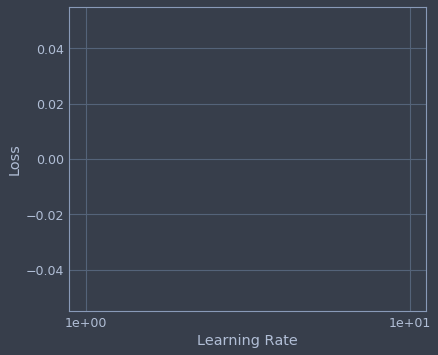

In [43]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
torch.cuda.empty_cache()

In [44]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5))
torch.cuda.empty_cache()

In [45]:
learn.save('densenet161_256_test_unfreeze')
torch.cuda.empty_cache()

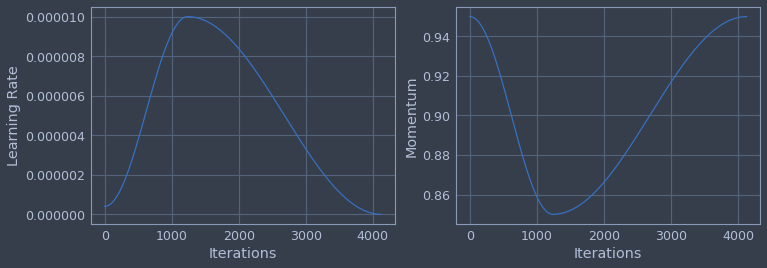

In [46]:
learn.recorder.plot_lr(show_moms=True)

In [47]:
ci = ClassificationInterpretation.from_learner(learn)

In [48]:
ci.confusion_matrix()

array([[1641,   38],
       [   5, 1620]])

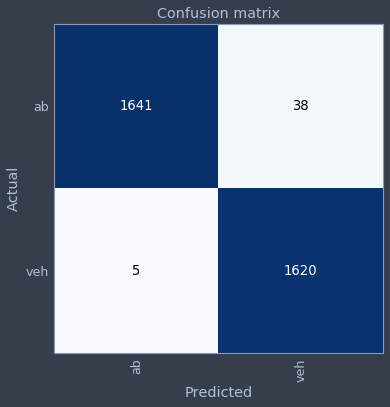

In [49]:
ci.plot_confusion_matrix()

In [50]:
ci.most_confused()

[('ab', 'veh', 38), ('veh', 'ab', 5)]

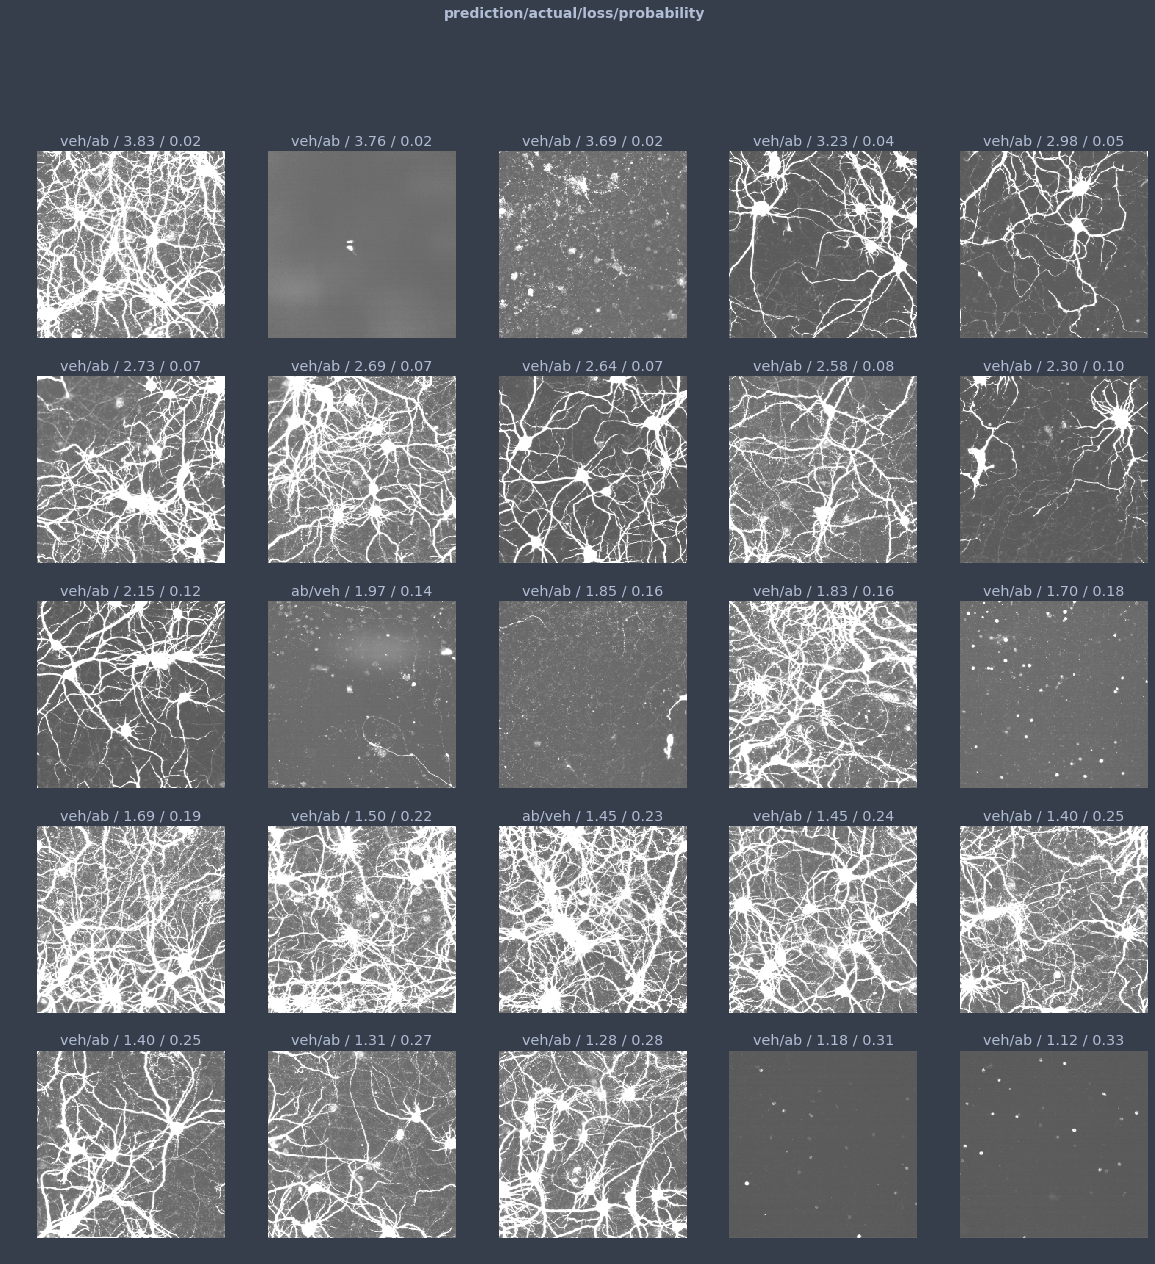

In [51]:
ci.plot_top_losses(25, figsize=(20,20))

# Training at 512 resolution

In [275]:
data = ImageDataBunch.from_df(path_to_images, 
                              dfs[['filename_new', 'treatment']],
                              ds_tfms=get_transforms(),
                              valid_pct=VALID_PCT, 
                              bs=8,
                              size=512).normalize(imagenet_stats)

In [277]:
learn = cnn_learner(data, models.densenet161, metrics=accuracy, bn_final=True, 
                    model_dir='/mnt/sdf/adam/models')
learn.load('densenet161_256_test_unfreeze')
learn.model = torch.nn.DataParallel(learn.model)
torch.cuda.empty_cache()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


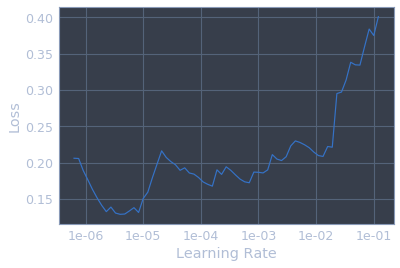

In [24]:
learn.lr_find()
learn.recorder.plot()
torch.cuda.empty_cache()

In [278]:
learn.fit_one_cycle(8, max_lr=slice(1e-4, 1e-3))
torch.cuda.empty_cache()

In [279]:
learn.model = learn.model.module
learn.save('densenet161_512_test')

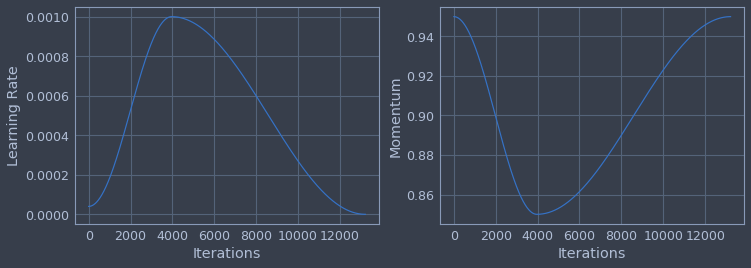

In [280]:
learn.recorder.plot_lr(show_moms=True)

In [281]:
ci = ClassificationInterpretation.from_learner(learn)

In [282]:
ci.confusion_matrix()

array([[1647,   20],
       [   5, 1632]])

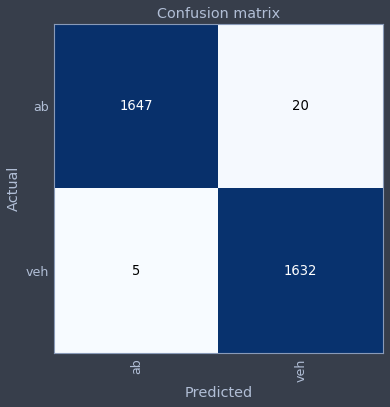

In [283]:
ci.plot_confusion_matrix()

In [284]:
ci.most_confused()

[('ab', 'veh', 20), ('veh', 'ab', 5)]

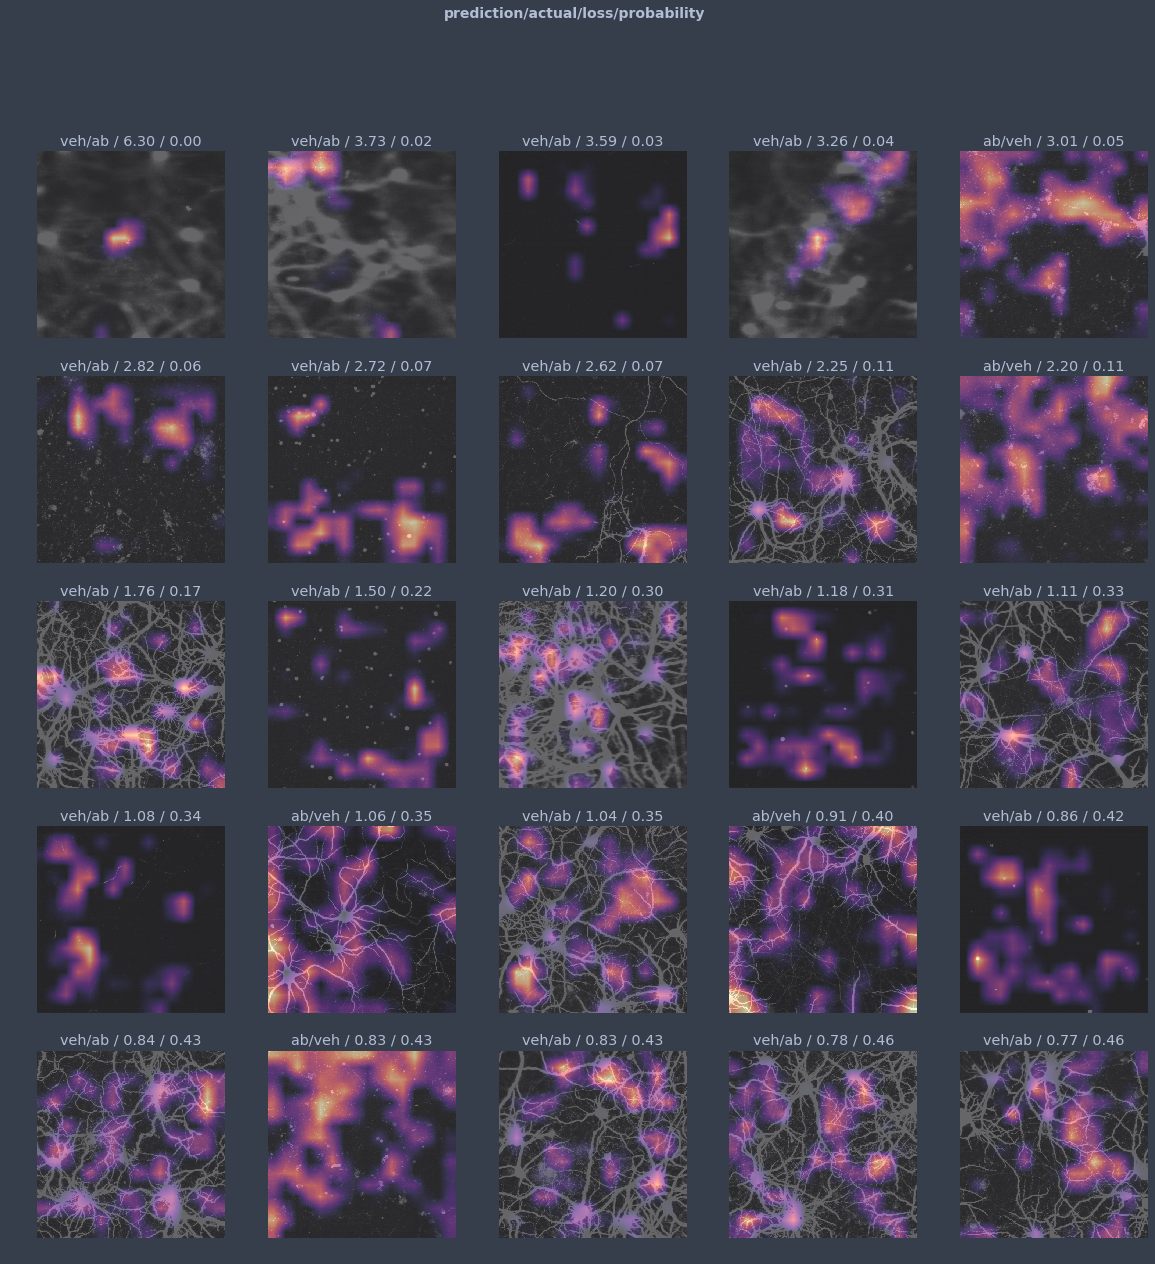

In [285]:
ci.plot_top_losses(25, figsize=(20,20))

# Training with 1024 resolution

In [21]:
data = ImageDataBunch.from_df(path_to_images, 
                              dfs[['filename_new', 'treatment']],
                              ds_tfms=get_transforms(),
                              valid_pct=VALID_PCT, 
                              bs=2,
                              size=1024).normalize(imagenet_stats)

In [22]:
learn = cnn_learner(data, models.densenet161, metrics=accuracy, bn_final=True, 
                    model_dir='/mnt/sdf/adam/models')
learn.load('densenet161_512_test')
learn.model = torch.nn.DataParallel(learn.model)
torch.cuda.empty_cache()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


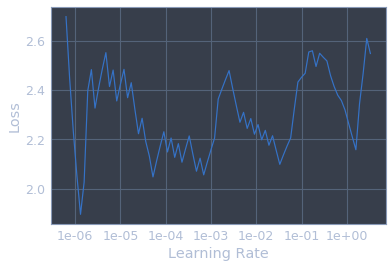

In [24]:
learn.lr_find()
learn.recorder.plot()
torch.cuda.empty_cache()

In [25]:
learn.fit_one_cycle(10, max_lr=slice(1e-5, 5e-3))
torch.cuda.empty_cache()

In [26]:
learn.save('densenet161_1024_test')

In [23]:
learn.load('densenet161_1024_test');

In [24]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


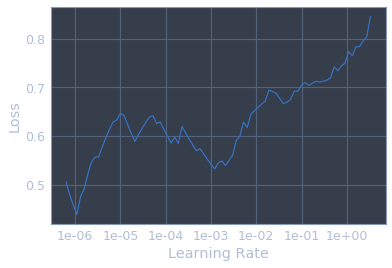

In [26]:
learn.lr_find()
learn.recorder.plot()
torch.cuda.empty_cache()

In [25]:
learn.fit_one_cycle(10, max_lr=slice(1e-5, 5e-4))
torch.cuda.empty_cache()

In [22]:
learn.save('densenet161_1024_test_unfreeze')

NameError: name 'learn' is not defined

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 5e-4))